This notebook conducts macroeconomic stress tests to evaluate the resilience of Ghana’s banking sector.
The analysis translates extreme but plausible macroeconomic shocks into changes in asset quality,
focusing on the Non-Performing Loan (NPL) Ratio.

Inputs:
- Cleaned and processed macro-financial dataset
- Estimated econometric relationships from prior modeling

Outputs:
- Static (OLS-based) stress scenarios
- Dynamic (VAR-based) stress paths
- Visual diagnostics for regulatory interpretation


In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.api import VAR
from statsmodels.api import OLS, add_constant

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings("ignore")
plt.rcParams.update({
    "figure.figsize": (10, 5),
    "axes.titlesize": 14,
    "axes.labelsize": 11,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
})
df = pd.read_csv("../data/processed/ghana_banking_master.csv")
df["Date"] = pd.to_datetime(df["Date"])
df = df.set_index("Date").sort_index()

In [2]:
print("\n\n" + "=" * 70)
print("STRESS TESTING SCENARIOS — STATIC MACRO-FINANCIAL TRANSMISSION")
print("=" * 70)
print("Simulating extreme but plausible macroeconomic shocks\n")




STRESS TESTING SCENARIOS — STATIC MACRO-FINANCIAL TRANSMISSION
Simulating extreme but plausible macroeconomic shocks



In [3]:
current_npl = df['Non Performing Loan Ratio'].iloc[-1]
npl_mean = df['Non Performing Loan Ratio'].mean()
npl_std = df['Non Performing Loan Ratio'].std()

print(f"Current NPL Ratio        : {current_npl:.2f}%")
print(f"Historical Mean NPL      : {npl_mean:.2f}%")
print(f"Historical Std Deviation : {npl_std:.2f}%\n")


Current NPL Ratio        : 21.74%
Historical Mean NPL      : 16.97%
Historical Std Deviation : 3.65%



In [4]:
stress_vars = [
    'Monetary Policy Rate (%)',
    'USD Exchange Rate, monthly averages',
    'Consumer Price Index, All Items',
    'GDP_Real'
]

X = df[stress_vars].dropna()
y = df.loc[X.index, 'Non Performing Loan Ratio']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

stress_model = LinearRegression()
stress_model.fit(X_scaled, y)

print("Stress transmission model fitted successfully.")


Stress transmission model fitted successfully.


In [5]:
latest = df.iloc[-1]

scenarios = {
    "Baseline": {
        "Monetary Policy Rate (%)": latest['Monetary Policy Rate (%)'],
        "USD Exchange Rate, monthly averages": latest['USD Exchange Rate, monthly averages'],
        "Consumer Price Index, All Items": latest['Consumer Price Index, All Items'],
        "GDP_Real": latest['GDP_Real']
    },

    "Moderate Tightening": {
        "Monetary Policy Rate (%)": latest['Monetary Policy Rate (%)'] + 2,
        "USD Exchange Rate, monthly averages": latest['USD Exchange Rate, monthly averages'] * 1.05,
        "Consumer Price Index, All Items": latest['Consumer Price Index, All Items'] * 1.05,
        "GDP_Real": latest['GDP_Real'] * 0.98
    },

    "Severe Currency Crisis": {
        "Monetary Policy Rate (%)": latest['Monetary Policy Rate (%)'] + 4,
        "USD Exchange Rate, monthly averages": latest['USD Exchange Rate, monthly averages'] * 1.30,
        "Consumer Price Index, All Items": latest['Consumer Price Index, All Items'] * 1.20,
        "GDP_Real": latest['GDP_Real'] * 0.95
    },

    "Severe Recession": {
        "Monetary Policy Rate (%)": latest['Monetary Policy Rate (%)'] - 1,
        "USD Exchange Rate, monthly averages": latest['USD Exchange Rate, monthly averages'] * 1.15,
        "Consumer Price Index, All Items": latest['Consumer Price Index, All Items'],
        "GDP_Real": latest['GDP_Real'] * 0.85
    }
}


In [6]:
print("=" * 70)
print("STRESS TEST RESULTS")
print("=" * 70)

baseline_vector = np.array([[scenarios['Baseline'][v] for v in stress_vars]])
baseline_scaled = scaler.transform(baseline_vector)
baseline_npl = stress_model.predict(baseline_scaled)[0]

results = []

for name, values in scenarios.items():
    X_scenario = np.array([[values[v] for v in stress_vars]])
    X_scaled_scenario = scaler.transform(X_scenario)

    predicted_npl = stress_model.predict(X_scaled_scenario)[0]

    results.append({
        "Scenario": name,
        "Predicted NPL (%)": round(predicted_npl, 2),
        "Δ vs Current (pp)": round(predicted_npl - current_npl, 2),
        "Δ vs Baseline (pp)": round(predicted_npl - baseline_npl, 2)
    })

    print(f"\n{name}")
    print(f"Predicted NPL Ratio : {predicted_npl:.2f}%")
    print(f"Change vs Current   : {predicted_npl - current_npl:+.2f} pp")
    print(f"Change vs Baseline  : {predicted_npl - baseline_npl:+.2f} pp")


STRESS TEST RESULTS

Baseline
Predicted NPL Ratio : 24.39%
Change vs Current   : +2.65 pp
Change vs Baseline  : +0.00 pp

Moderate Tightening
Predicted NPL Ratio : 25.26%
Change vs Current   : +3.52 pp
Change vs Baseline  : +0.87 pp

Severe Currency Crisis
Predicted NPL Ratio : 27.21%
Change vs Current   : +5.47 pp
Change vs Baseline  : +2.82 pp

Severe Recession
Predicted NPL Ratio : 24.89%
Change vs Current   : +3.15 pp
Change vs Baseline  : +0.50 pp


The stress test results reveal that a Severe Currency Crisis is the most significant threat to financial stability, potentially driving the NPL ratio to a peak of 27.21%. Even under the Baseline scenario, the model predicts a +2.65 pp increase in defaults compared to current levels. Overall, loan quality shows a higher sensitivity to exchange rate volatility and Moderate Tightening than to a Severe Recession.

In [7]:
stress_results_df = pd.DataFrame(results)
stress_results_df


,Scenario,Predicted NPL (%),Δ vs Current (pp),Δ vs Baseline (pp)
0,Baseline,24.39,2.65,0.00
1,Moderate Tightening,25.26,3.52,0.87
2,Severe Currency Crisis,27.21,5.47,2.82
3,Severe Recession,24.89,3.15,0.50


A Severe Currency Crisis poses the greatest threat, potentially increasing the NPL ratio by 5.47 percentage points (pp) above current levels to a peak of 27.21%.

Loan quality is more vulnerable to Moderate Tightening (interest rate hikes) than a Severe Recession, showing a +0.87 pp increase versus a +0.50 pp increase over the baseline, respectively.

Even under standard economic conditions, the model projects a +2.65 pp rise in defaults compared to the current standing.

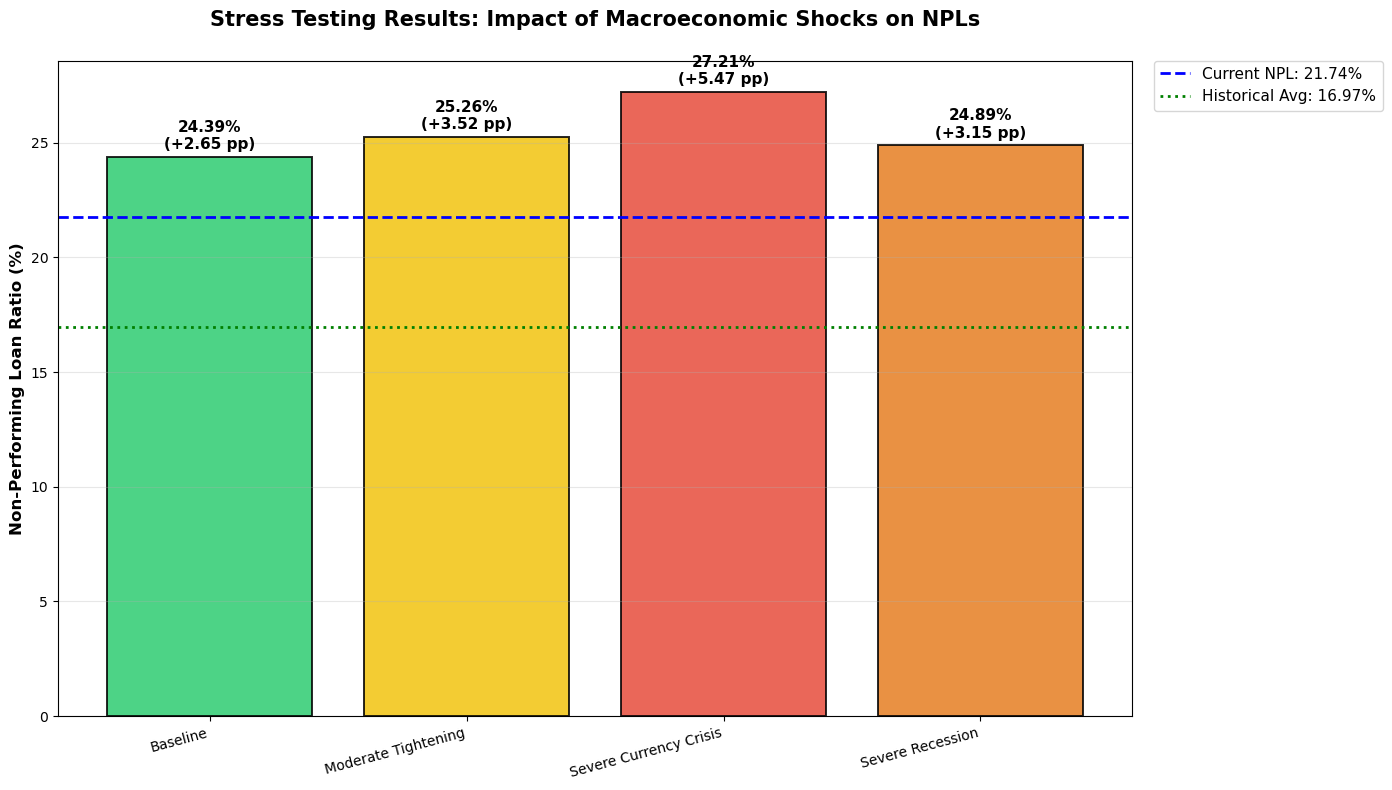

In [8]:
# Converting stress results to DataFrame
stress_plot_df = pd.DataFrame(results)

scenario_order = [
    'Baseline',
    'Moderate Tightening',
    'Severe Currency Crisis',
    'Severe Recession'
]

stress_plot_df['Scenario'] = pd.Categorical(
    stress_plot_df['Scenario'],
    categories=scenario_order,
    ordered=True
)
stress_plot_df = stress_plot_df.sort_values('Scenario')

# Extract values
scenario_names = stress_plot_df['Scenario'].tolist()
predicted_npls = stress_plot_df['Predicted NPL (%)'].values
impact_current = stress_plot_df['Δ vs Current (pp)'].values

# Color mapping
color_map = {
    'Baseline': '#2ecc71',
    'Moderate Tightening': '#f1c40f',
    'Severe Currency Crisis': '#e74c3c',
    'Severe Recession': '#e67e22'
}
colors = [color_map[s] for s in scenario_names]


fig, ax = plt.subplots(figsize=(14, 8))

bars = ax.bar(
    range(len(scenario_names)),
    predicted_npls,
    color=colors,
    edgecolor='black',
    linewidth=1.4,
    alpha=0.85
)

ax.axhline(
    y=current_npl,
    color='blue',
    linestyle='--',
    linewidth=2,
    label=f'Current NPL: {current_npl:.2f}%'
)

ax.axhline(
    y=npl_mean,
    color='green',
    linestyle=':',
    linewidth=2,
    label=f'Historical Avg: {npl_mean:.2f}%'
)

for bar, impact in zip(bars, impact_current):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.2,
        f"{height:.2f}%\n({impact:+.2f} pp)",
        ha='center',
        va='bottom',
        fontsize=11,
        fontweight='bold'
    )


ax.set_xticks(range(len(scenario_names)))
ax.set_xticklabels(scenario_names, rotation=15, ha='right')
ax.set_ylabel('Non-Performing Loan Ratio (%)', fontsize=12, fontweight='bold')

ax.set_title(
    'Stress Testing Results: Impact of Macroeconomic Shocks on NPLs',
    fontsize=15,
    fontweight='bold',
    pad=25
)


ax.legend(
    fontsize=11,
    loc='upper left',
    bbox_to_anchor=(1.02, 1),
    borderaxespad=0
)

ax.grid(axis='y', alpha=0.3)


plt.subplots_adjust(right=0.80)
plt.tight_layout()
plt.savefig('../figures/npl_stress_testing_results.png', dpi=300, bbox_inches='tight')
plt.show()

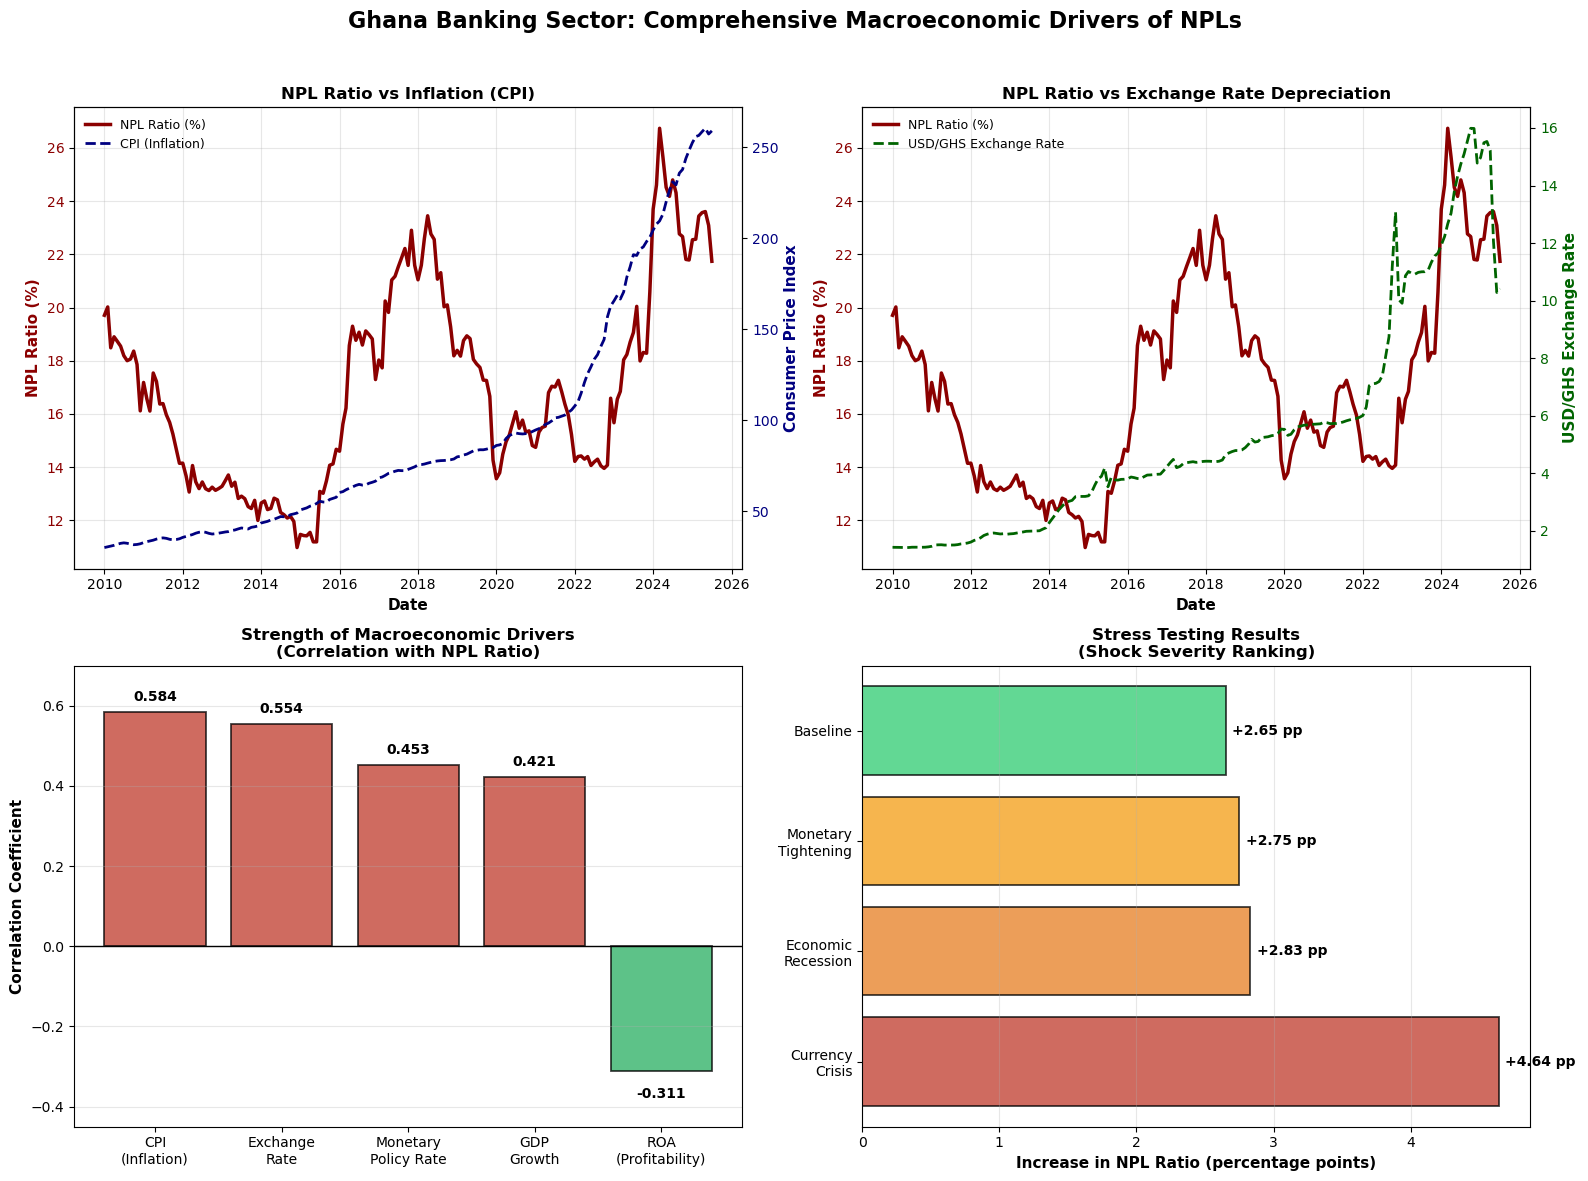

In [9]:
### NPL DRIVER IMPACT DASHBOARD
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. NPL vs Inflation (CPI)
ax1 = axes[0, 0]
ax1_2 = ax1.twinx()

npl_line = ax1.plot(
    df.index,
    df['Non Performing Loan Ratio'],
    color='darkred',
    linewidth=2.5,
    label='NPL Ratio (%)'
)

inflation_line = ax1_2.plot(
    df.index,
    df['Consumer Price Index, All Items'],
    color='navy',
    linestyle='--',
    linewidth=2,
    label='CPI (Inflation)'
)

ax1.set_xlabel('Date', fontweight='bold')
ax1.set_ylabel('NPL Ratio (%)', color='darkred', fontweight='bold')
ax1_2.set_ylabel('Consumer Price Index', color='navy', fontweight='bold')

ax1.tick_params(axis='y', labelcolor='darkred')
ax1_2.tick_params(axis='y', labelcolor='navy')

ax1.set_title('NPL Ratio vs Inflation (CPI)', fontweight='bold', fontsize=12)
ax1.grid(True, alpha=0.3)

lines = npl_line + inflation_line
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left', fontsize=9, frameon=False)

# 2. NPL vs Exchange Rate
ax2 = axes[0, 1]
ax2_2 = ax2.twinx()

npl_line2 = ax2.plot(
    df.index,
    df['Non Performing Loan Ratio'],
    color='darkred',
    linewidth=2.5,
    label='NPL Ratio (%)'
)

fx_line = ax2_2.plot(
    df.index,
    df['USD Exchange Rate, monthly averages'],
    color='darkgreen',
    linestyle='--',
    linewidth=2,
    label='USD/GHS Exchange Rate'
)

ax2.set_xlabel('Date', fontweight='bold')
ax2.set_ylabel('NPL Ratio (%)', color='darkred', fontweight='bold')
ax2_2.set_ylabel('USD/GHS Exchange Rate', color='darkgreen', fontweight='bold')

ax2.tick_params(axis='y', labelcolor='darkred')
ax2_2.tick_params(axis='y', labelcolor='darkgreen')

ax2.set_title('NPL Ratio vs Exchange Rate Depreciation', fontweight='bold', fontsize=12)
ax2.grid(True, alpha=0.3)

lines = npl_line2 + fx_line
labels = [l.get_label() for l in lines]
ax2.legend(lines, labels, loc='upper left', fontsize=9, frameon=False)

# 3. Driver Strength (Correlations)
ax3 = axes[1, 0]

drivers = [
    'CPI\n(Inflation)',
    'Exchange\nRate',
    'Monetary\nPolicy Rate',
    'GDP\nGrowth',
    'ROA\n(Profitability)'
]

correlations = [0.584, 0.554, 0.453, 0.421, -0.311]

colors_drivers = [
    '#c0392b' if c > 0 else '#27ae60'
    for c in correlations
]

bars = ax3.bar(
    drivers,
    correlations,
    color=colors_drivers,
    alpha=0.75,
    edgecolor='black',
    linewidth=1.3
)

ax3.axhline(0, color='black', linewidth=1)
ax3.set_ylabel('Correlation Coefficient', fontweight='bold')
ax3.set_title(
    'Strength of Macroeconomic Drivers\n(Correlation with NPL Ratio)',
    fontweight='bold',
    fontsize=12
)
ax3.set_ylim(-0.45, 0.70)
ax3.grid(axis='y', alpha=0.3)

for bar, corr in zip(bars, correlations):
    ax3.text(
        bar.get_x() + bar.get_width() / 2,
        corr + (0.02 if corr > 0 else -0.04),
        f'{corr:.3f}',
        ha='center',
        va='bottom' if corr > 0 else 'top',
        fontsize=10,
        fontweight='bold'
    )

# 4. Shock Severity Ranking
ax4 = axes[1, 1]

shock_types = [
    'Currency\nCrisis',
    'Economic\nRecession',
    'Monetary\nTightening',
    'Baseline'
]

impacts = [4.64, 2.83, 2.75, 2.65]

colors_shocks = ['#c0392b', '#e67e22', '#f39c12', '#2ecc71']

bars_shock = ax4.barh(
    shock_types,
    impacts,
    color=colors_shocks,
    alpha=0.75,
    edgecolor='black',
    linewidth=1.3
)

ax4.set_xlabel('Increase in NPL Ratio (percentage points)', fontweight='bold')
ax4.set_title(
    'Stress Testing Results\n(Shock Severity Ranking)',
    fontweight='bold',
    fontsize=12
)
ax4.grid(axis='x', alpha=0.3)

for bar, impact in zip(bars_shock, impacts):
    ax4.text(
        impact + 0.05,
        bar.get_y() + bar.get_height() / 2,
        f'+{impact:.2f} pp',
        va='center',
        ha='left',
        fontsize=10,
        fontweight='bold'
    )

### Title
plt.suptitle(
    'Ghana Banking Sector: Comprehensive Macroeconomic Drivers of NPLs',
    fontsize=16,
    fontweight='bold',
    y=0.98
)

plt.subplots_adjust(hspace=0.30, wspace=0.22)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('../figures/npl_driver_impact_dashboard.png', dpi=300, bbox_inches='tight')
plt.show()

The data suggests that the health of Ghana's banking sector is highly sensitive to inflationary pressures and currency depreciation. Currently, the sector is coming off a record high NPL peak in 2024, with currency stability remaining the most critical factor for preventing future loan defaults.